In [1]:
%matplotlib inline
########## DISABLE GPU
import os
import sys

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
sys.path.append("../vsegmenter")

import numpy as np
import tensorflow as tf
from eval.run_eval import load_model
from data.dataset import Dataset
from vsegmenter import cfg
from matplotlib import pyplot as plt

cfg.configLog()

import logging

In [2]:
def plot_images(sample, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,20))
    
    ax[0].matshow(sample["image"]); ax[0].set_title(sample["filename"]); ax[0].axis('off')
    ax[1].matshow((sample["mask"]*255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[1].set_title(f"Extraction {sample['extraction']}"); ax[1].axis('off')
    ax[2].matshow((sample["prediction"]*255), cmap="gray", vmin=0, vmax=255) 
    ax[2].set_title(f"Predicted Mask {sample['count']}"); ax[2].axis('off')
    
def plot_image(sample):
    plt.imshow((sample*255).astype(np.uint8))
    

In [3]:
version = "v5"
model_label = "unet"
img_size = 128

dataset_file = cfg.dataset(f'{version}/dataset_{img_size}.pickle')
x_train, y_train, x_val, y_val = Dataset.load_from_file(dataset_file)

# x_val = x_val[:20]
# y_val = y_val[:20]
x_val = x_train
y_val = y_train

print(f"Num samples: {len(y_val)}")


2023-04-29 22:38:17 INFO Number of train samples: 1678, test samples = 420
2023-04-29 22:38:17 INFO Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 2)
2023-04-29 22:38:17 INFO Original image shape : (1678, 128, 128, 3)


Num samples: 1678


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from skimage.transform import resize
from tensorflow.python.keras import backend as K


new_size = (224,224)
dts_images = x_val
resized_images = np.zeros((dts_images.shape[0], *new_size, 3))
for i in range(dts_images.shape[0]):
    resized_images[i] = resize(dts_images[i], new_size)


K.clear_session()
tf.keras.backend.clear_session()

    
# Extraer las características de las imágenes
model = ResNet50(weights='imagenet', include_top=True)
logging.info(f"Extracting image features {len(dts_images)}")
features = model.predict(resized_images)
logging.info(f"Finished {features.shape}")


2023-04-29 22:38:44.410658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 22:38:44.443939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 22:38:44.444471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 22:38:44.462141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
sse = []
for num_clusters in range(1, 15):
    model = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
    logging.info(f"Running kmeans with num_clusters={num_clusters}")
    sse.append(model.inertia_)

num_clusters=1
num_clusters=2
num_clusters=3
num_clusters=4
num_clusters=5
num_clusters=6
num_clusters=7
num_clusters=8
num_clusters=9
num_clusters=10
num_clusters=11
num_clusters=12
num_clusters=13
num_clusters=14


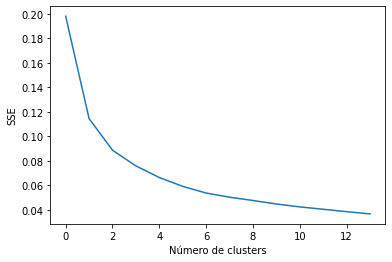

In [7]:
plt.plot(range(len(sse)), sse)
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.show()

In [9]:
# Aplicar clustering K-means
NUM_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(features)

# Obtener las etiquetas de clustering
labels = kmeans.labels_

# Imprimir las etiquetas de cada imagen
clusters = {}
image_labels = []
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(i)
    image_labels.append(label)


In [10]:
dts_images[0,:].shape


(128, 128, 3)

In [11]:
def plot_cluster(images, max_images=30):
    num_images = min(len(images),max_images)
    samples = []
    for idx in images[:num_images]:
        samples.append((255*dts_images[idx,:]).astype(np.uint8))
    plot_image_list(samples)

def plot_image_list(images, grid_columns=4):
    num_images = len(images)
    grid_rows = (num_images + grid_columns - 1) // grid_columns

    # Crear una figura y mostrar las imágenes en una cuadrícula
    fig, axs = plt.subplots(grid_rows, grid_columns, figsize=(16, grid_rows * 4))

    for i in range(grid_rows):
        for j in range(grid_columns):
            index = i * grid_columns + j
            if index < num_images:
                img = images[index]
                axs[i, j].imshow( img)
                axs[i, j].axis('off')
            else:
                axs[i, j].remove()

    plt.show()

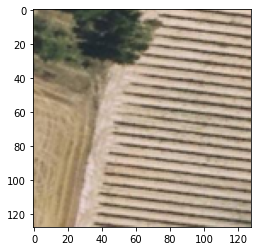

In [12]:
plt.imshow((dts_images[0,:]*255).astype(np.uint8))


Number of images per cluster:


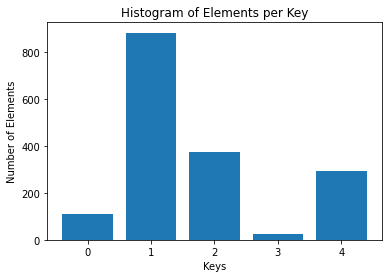

In [17]:
print(f"Number of images per cluster:")
counts = {key: len(value_list) for key, value_list in clusters.items()}

# Crear el histograma
keys = list(counts.keys())
values = list(counts.values())

plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Number of Elements')
plt.title('Histogram of Elements per Key')
plt.show()

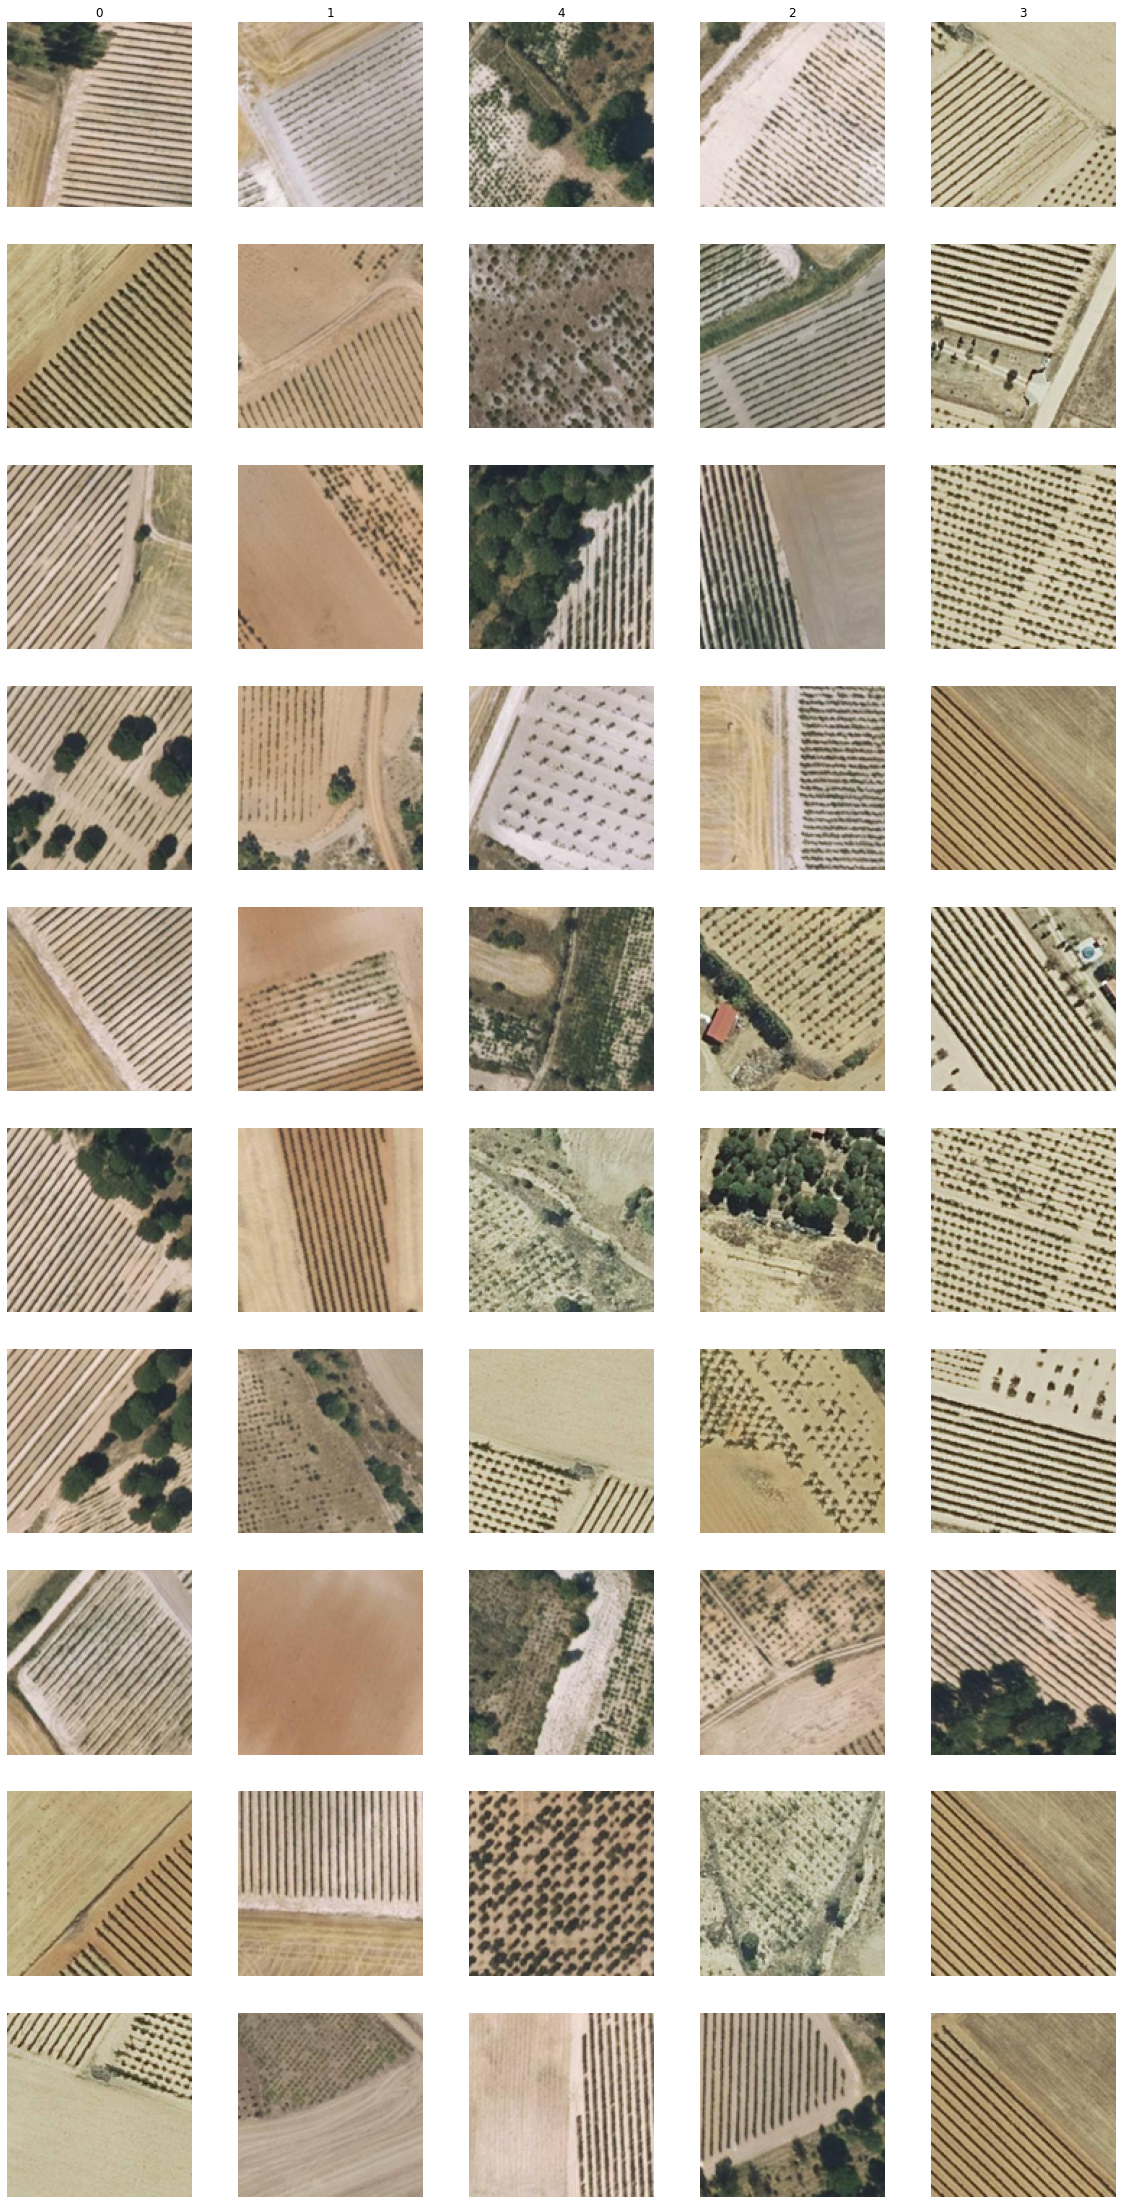

In [34]:
grid_columns = len(clusters)
grid_rows = 10

# Crear una figura y mostrar las imágenes en una cuadrícula
fig, axs = plt.subplots(grid_rows, grid_columns, figsize=(4 * grid_columns, 4 * grid_rows))

for i, (cluster_label, images) in enumerate(clusters.items()):
    for j in range(grid_rows):
        if j < len(images):
            idx = images[j]
            image = (255*dts_images[idx,:]).astype(np.uint8)
            axs[j, i].imshow(image)
            axs[j, i].axis('off')
        else:
            axs[j, i].remove()
    axs[0, i].set_title(cluster_label)

plt.show()


In [ ]:
from sklearn.manifold import TSNE

# Project features using tSNE
# Aplicar t-SNE
tsne = TSNE(n_components=2)
projected_features = tsne.fit_transform(features.reshape(features.shape[0], -1))

# Graficar los puntos proyectados
# plt.scatter(projected_features[:, 0], projected_features[:, 1])
# plt.show()


# Crea la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Grafica los puntos en la proyección TSNE y agrega una etiqueta para cada punto
scatter = ax.scatter(projected_features[:,0], projected_features[:,1], c=image_labels)

# Recorre todos los puntos y agrega el ID de la imagen en su ubicación
for i, txt in enumerate(range(len(image_labels))):
    ax.annotate(txt, (projected_features[i,0], projected_features[i,1]))

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = ax.text(j, i, image[i, j], ha="center", va="center", color="w")
 

# Agrega una barra de color para mostrar los índices correspondientes a los puntos
colorbar = plt.colorbar(scatter)

# Define la función que muestra la imagen correspondiente cuando haces clic en un punto
def on_click(event):
#     if event.inaxes == ax:
    index = int(event.ind[0])
#         image = images[index] 
    image = dts_images[index,:]
    print("asdfasfas")
    plt.figure()
    plt.imshow(image)
    plt.show()

# Agrega la función de clic a la figura
fig.canvas.mpl_connect('button_press_event', on_click)

# Muestra la figura
plt.show()


/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
